## Project : Analysis of rainfall trends with Satellite Raster Data 
```bash
The Aim of this project is to analyze and predict rainfall trends in Delhi NCR using satellite-derived monthly precipitation data, advanced statistical methods, and machine learning models, while leveraging cloud-based processing to avoid large local downloads.

Deliverable: A year-long rainfall forecast using multiple ML algorithms, with visualization and tabular output for presentation or decision-making.
```
---

#### Rainfall Trend Analysis for Delhi NCR Using Google Earth Engine

1. The data source is `NASA's GPM IMERG` (Global Precipitation Measurement, Integrated Multi-satellitE Retrievals for GPM). It is a spatial raster (gridded) dataset, where each grid cell represents estimated monthly rainfall
2. All visualizations and analysis start from this satellite-based raster data, which is extracted, transformed, and summarized for Delhi NCR.

#### Project Overview

1. **Google Earth Engine**: Cloud-based satellite data access (no large downloads needed)
2. **NASA GPM IMERG Monthly**: High-quality global precipitation measurements
3. **Statistical Analysis**: Mann-Kendall trend test, Sen's Slope
4. **Machine Learning**: Random Forest, XGBoost, LSTM models
5. **Visualization**: Comprehensive plots and interactive charts

#### Key Advantages:

1. **No massive downloads**: `77,000+` Images in earlier half-hourly data` 
2. **Fast extraction**: Takes `2-5 minutes` instead of hours  
3. **20-year analysis**: Extended from `2004-2024` for better trend detection  
4. **Cloud processing**: Leverages Google's infrastructure  
5. **Reproducible**: Easy to extend to other regions or time periods  

---

- **Author:** `Ansh Gupta-(25CS60R34) & Prakhar Prajapati-(25CS60R66)`
- **Institution:** `IIT Kharagpur, M.Tech Computer Science and Engineering`  
- **Duration:** `July-November, 2025`  
- **Data Source:** `NASA GPM IMERG Monthly via Google Earth Engine`  
- **Region:** `Delhi NCR, India`
- **Coordinates:** `28.0-29.5°N, 76.5-77.8°E`  
- **Time Period:** `2004-2024 (20 years)` 

---
### 1. Packages Installation

In [1]:

%pip install earthengine-api geemap -q
%pip install numpy pandas matplotlib seaborn scikit-learn xgboost scipy statsmodels tensorflow -q

print("✓ All packages installed successfully!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✓ All packages installed successfully!


---
#### 2. Imports for Data Processing, Machine Learning

In [ ]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

from scipy import stats

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set plotting styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

/home/ansh/miniconda3/envs/ML/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


✓ All libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.0.1
Pandas version: 2.3.3


---
#### 3. Intialize GEE Authentication - `Google Earth Engine`

In [3]:
try:
    ee.Initialize()
    print("✓ Earth Engine initialized successfully!")
except Exception as e:
    print("Authenticating Earth Engine...")
    ee.Authenticate()
    ee.Initialize()
    print("✓ Earth Engine authenticated and initialized!")

✓ Earth Engine initialized successfully!


---
#### 4. Configuration and Setup

In [4]:
PROCESSED_DIR = './data/processed'
RESULTS_DIR = './results'
MODELS_DIR = './models'

# Create directories
for directory in [PROCESSED_DIR, RESULTS_DIR, MODELS_DIR]:
    os.makedirs(directory, exist_ok=True)

# Delhi NCR bounding box coordinates
DELHI_BBOX = {
    'min_lon': 76.5,
    'max_lon': 77.8,
    'min_lat': 28.0,
    'max_lat': 29.5
}

# Create Earth Engine geometry for Delhi NCR
delhi_geometry = ee.Geometry.Rectangle([
    DELHI_BBOX['min_lon'],
    DELHI_BBOX['min_lat'],
    DELHI_BBOX['max_lon'],
    DELHI_BBOX['max_lat']
])

START_DATE = '2004-10-31'
END_DATE = '2024-10-31'

print("✓ Configuration set successfully!")
print(f"Delhi NCR Bounding Box: {DELHI_BBOX}")
print(f"Analysis Period: {START_DATE} to {END_DATE} (10 years)")

✓ Configuration set successfully!
Delhi NCR Bounding Box: {'min_lon': 76.5, 'max_lon': 77.8, 'min_lat': 28.0, 'max_lat': 29.5}
Analysis Period: 2004-10-31 to 2024-10-31 (10 years)


---
#### 5. Load Monthly Rainfall Data from Google Earth Engine
`Using NASA GPM IMERG V07 **Monthly** dataset for fast extraction.`

In [5]:
print("Loading NASA GPM IMERG Monthly rainfall data from Google Earth Engine...\n")

gpm_monthly = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V07') \
    .filterDate(START_DATE, END_DATE) \
    .filterBounds(delhi_geometry) \
    .select('precipitation')  # Monthly precipitation

# Get collection size
collection_size = gpm_monthly.size().getInfo()
print(f"✓ Loaded {collection_size} monthly images from GPM IMERG dataset")
print(f"  Date Range: {START_DATE} to {END_DATE}")
print(f"  Region: Delhi NCR")
print(f"\nDataset Details:")
print(f"  - Temporal Resolution: Monthly")
print(f"  - Spatial Resolution: 0.1° (~11 km)")
print(f"  - Units: mm/month")
print(f"  - Expected extraction time: 2-5 minutes")

Loading NASA GPM IMERG Monthly rainfall data from Google Earth Engine...

✓ Loaded 240 monthly images from GPM IMERG dataset
  Date Range: 2004-10-31 to 2024-10-31
  Region: Delhi NCR

Dataset Details:
  - Temporal Resolution: Monthly
  - Spatial Resolution: 0.1° (~11 km)
  - Units: mm/month
  - Expected extraction time: 2-5 minutes


##### 5.1 Extract Monthly Rainfall Time Series for Delhi NCR
Monthly data, so extraction is much faster (~2-5 minutes for ~240 months).

In [6]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd

def extract_monthly_rainfall_timeseries(image_collection, region):
    
    # Get image list
    image_list = image_collection.toList(image_collection.size())
    n_images = image_collection.size().getInfo()
    
    print(f"Extracting rainfall data for {n_images} months...")
    print("This should take 2-5 minutes...\n")
    
    # Extract data with progress indicator
    data = []
    for i in range(n_images):
        if i % 10 == 0:
            print(f"Progress: {i}/{n_images} months processed... ({100*i//n_images}%)")
        
        image = ee.Image(image_list.get(i))
        
        # Calculate mean rainfall over the region
        mean_dict = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000,
            maxPixels=1e9
        )
        
        # Get date and rainfall value
        date = image.date().format('YYYY-MM-dd').getInfo()
        rainfall_mm_per_hr = mean_dict.getInfo().get('precipitation', 0.0)
        
        date_obj = pd.to_datetime(date)
        days_in_month = (date_obj + MonthEnd(1)).day
        rainfall_mm_total = rainfall_mm_per_hr * 24 * days_in_month
        
        data.append({'date': date, 'monthly_rainfall_mm': rainfall_mm_total})
    
    print(f"\n✓ Extraction complete!")
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

# Extract time series
print("Starting data extraction from Google Earth Engine...\n")
df_monthly = extract_monthly_rainfall_timeseries(gpm_monthly, delhi_geometry)

print(f"\n{'='*70}")
print("DATA EXTRACTION SUMMARY")
print(f"{'='*70}")
print(f"Total records: {len(df_monthly)}")
print(f"Date range: {df_monthly['date'].min()} to {df_monthly['date'].max()}")
print(f"Mean monthly rainfall: {df_monthly['monthly_rainfall_mm'].mean():.2f} mm/month")
print(f"Max monthly rainfall: {df_monthly['monthly_rainfall_mm'].max():.2f} mm/month")
print(f"Min monthly rainfall: {df_monthly['monthly_rainfall_mm'].min():.2f} mm/month")
print(f"{'='*70}")

# Display first few rows
print("\nFirst 10 months:")
print(df_monthly.head(10))

Starting data extraction from Google Earth Engine...

Extracting rainfall data for 240 months...
This should take 2-5 minutes...

Progress: 0/240 months processed... (0%)
Progress: 10/240 months processed... (4%)
Progress: 20/240 months processed... (8%)
Progress: 30/240 months processed... (12%)
Progress: 40/240 months processed... (16%)
Progress: 50/240 months processed... (20%)
Progress: 60/240 months processed... (25%)
Progress: 70/240 months processed... (29%)
Progress: 80/240 months processed... (33%)
Progress: 90/240 months processed... (37%)
Progress: 100/240 months processed... (41%)
Progress: 110/240 months processed... (45%)
Progress: 120/240 months processed... (50%)
Progress: 130/240 months processed... (54%)
Progress: 140/240 months processed... (58%)
Progress: 150/240 months processed... (62%)
Progress: 160/240 months processed... (66%)
Progress: 170/240 months processed... (70%)
Progress: 180/240 months processed... (75%)
Progress: 190/240 months processed... (79%)
Prog

#### 5.2 Add Temporal Features

In [7]:
# Add temporal features
df_monthly['year'] = df_monthly['date'].dt.year
df_monthly['month'] = df_monthly['date'].dt.month
df_monthly['month_of_year'] = df_monthly['date'].dt.month  # For ML features

# Add season
df_monthly['season'] = df_monthly['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'monsoon', 7: 'monsoon', 8: 'monsoon', 9: 'monsoon',
    10: 'autumn', 11: 'autumn'
})

# Save processed data
df_monthly.to_csv(os.path.join(PROCESSED_DIR, 'delhi_monthly_rainfall_gee.csv'), index=False)

print("✓ Temporal features added!")
print(f"\nMonthly data shape: {df_monthly.shape}")
print("\nMonthly data summary:")
print(df_monthly[['monthly_rainfall_mm']].describe())
print("\nFirst 10 rows:")
print(df_monthly.head(10))

✓ Temporal features added!

Monthly data shape: (240, 6)

Monthly data summary:
       monthly_rainfall_mm
count           240.000000
mean             60.910763
std              78.223642
min               0.000000
25%               5.199134
50%              23.999971
75%              91.342482
max             334.567420

First 10 rows:
        date  monthly_rainfall_mm  year  month  month_of_year   season
0 2004-11-01             0.236807  2004     11             11   autumn
1 2004-12-01             1.460589  2004     12             12   winter
2 2005-01-01            16.022763  2005      1              1   winter
3 2005-02-01            55.325198  2005      2              2   winter
4 2005-03-01            43.906202  2005      3              3   spring
5 2005-04-01             8.544479  2005      4              4   spring
6 2005-05-01             8.084010  2005      5              5   spring
7 2005-06-01            51.526642  2005      6              6  monsoon
8 2005-07-01          

---
#### 6. Visualization with Interactive Map for `July 2024`

In [8]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd

july_2024_img_raw = gpm_monthly.filter(
    ee.Filter.calendarRange(7, 7, 'month')
).filter(
    ee.Filter.calendarRange(2024, 2024, 'year')
).first().clip(delhi_geometry)

target_month = pd.Timestamp('2024-07-01')
days_in_month = (target_month + MonthEnd(1)).day
print("Days in July 2024:", days_in_month)

# Convert mean rain rate (mm/hr) to total monthly rainfall (mm/month)
july_2024_img_mm = july_2024_img_raw.multiply(24 * days_in_month).rename('monthly_total_mm')

# Compute min and max for tight color scale
new_stats = july_2024_img_mm.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=delhi_geometry,
    scale=10000,
    maxPixels=1e9
).getInfo()

vmin = new_stats.get('monthly_total_mm_min')
vmax = new_stats.get('monthly_total_mm_max')
print(f"July 2024 rainfall min: {vmin:.2f} mm, max: {vmax:.2f} mm")

vis_params_july = {
    'min': max(0, vmin - 5),
    'max': vmax + 5,
    'palette': [
        'white', 'lightblue', 'cyan', 'lime', 'yellow',
        'orange', 'red', 'magenta', 'purple', 'black'
    ]
}

# Show map
Map = geemap.Map()
Map.centerObject(delhi_geometry, 9)
Map.addLayer(july_2024_img_mm, vis_params_july, 'Rainfall in July 2024 (mm/month)')
Map.addLayer(delhi_geometry, {'color': 'red'}, 'Delhi NCR Boundary')
print(f"Map: Rainfall in Delhi NCR, July 2024 (mm/month)\nColor scale: {vis_params_july['min']:.1f} – {vis_params_july['max']:.1f} mm")
Map

Days in July 2024: 31
July 2024 rainfall min: 129.46 mm, max: 276.77 mm
Map: Rainfall in Delhi NCR, July 2024 (mm/month)
Color scale: 124.5 – 281.8 mm


Map(center=[28.749758928267152, 77.14999999999993], controls=(WidgetControl(options=['position', 'transparent_…

---
#### 7. Exploratory Data Analysis

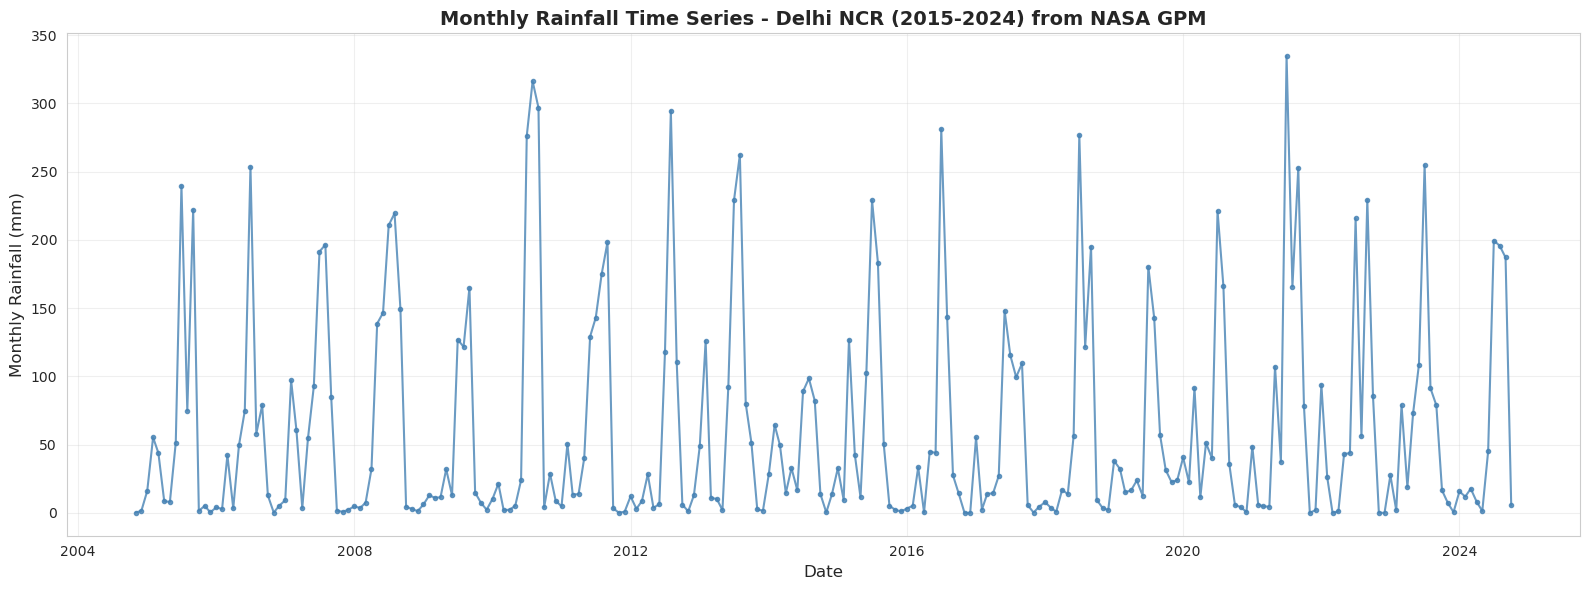

✓ Monthly rainfall time series plot created!


In [9]:
# Plot monthly rainfall time series
plt.figure(figsize=(16, 6))
plt.plot(df_monthly['date'], df_monthly['monthly_rainfall_mm'], linewidth=1.5, alpha=0.8, color='steelblue', marker='o', markersize=3)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Rainfall (mm)', fontsize=12)
plt.title('Monthly Rainfall Time Series - Delhi NCR (2015-2024) from NASA GPM', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'monthly_rainfall_timeseries_gee.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Monthly rainfall time series plot created!")

#### 7.1 - Average Rainfall by calendar month plot

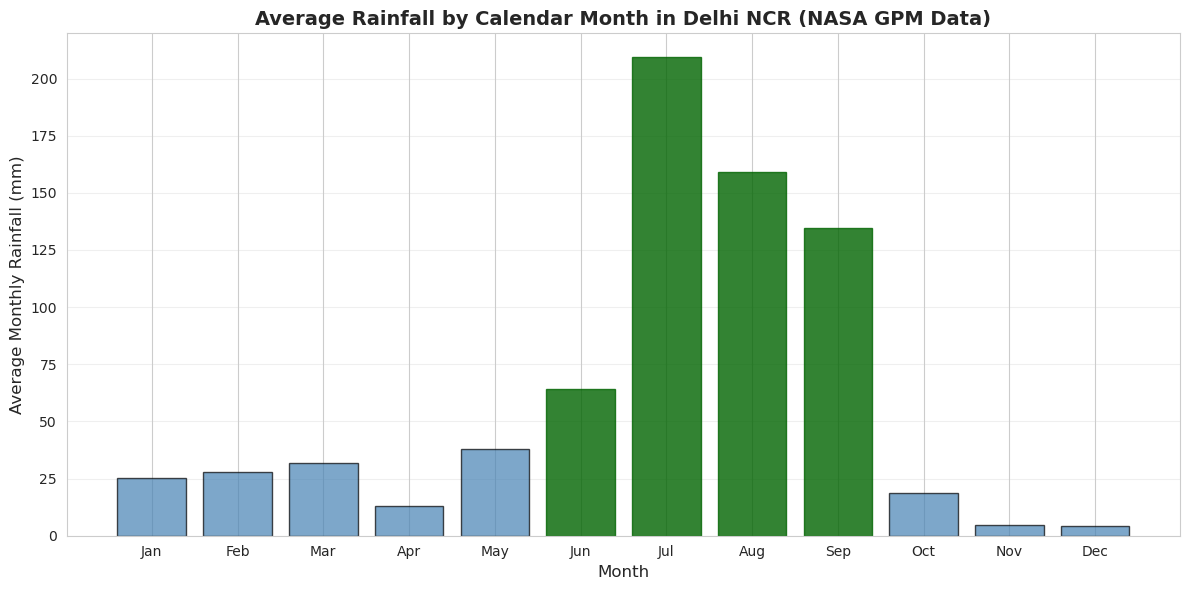


Average rainfall by calendar month:
 Jan:  25.41 mm
 Feb:  27.91 mm
 Mar:  31.65 mm
 Apr:  13.16 mm
 May:  38.15 mm
 Jun:  64.29 mm
 Jul: 209.30 mm
 Aug: 159.10 mm
 Sep: 134.57 mm
 Oct:  18.60 mm
 Nov:   4.48 mm
 Dec:   4.31 mm


In [10]:
# Calculate and plot average rainfall by calendar month
monthly_avg = df_monthly.groupby('month')['monthly_rainfall_mm'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_avg.index, monthly_avg.values, color='steelblue', alpha=0.7, edgecolor='black')

# Highlight monsoon months
for i, bar in enumerate(bars):
    if i+1 in [6, 7, 8, 9]:  # June-September
        bar.set_color('darkgreen')
        bar.set_alpha(0.8)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Monthly Rainfall (mm)', fontsize=12)
plt.title('Average Rainfall by Calendar Month in Delhi NCR (NASA GPM Data)', fontsize=14, fontweight='bold')
plt.xticks(range(1, 13), month_names)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'calendar_month_average_gee.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nAverage rainfall by calendar month:")
for i, val in enumerate(monthly_avg.values):
    print(f"{month_names[i]:>4s}: {val:6.2f} mm")

#### 7.2 - Calculate and plot annual rainfall trend

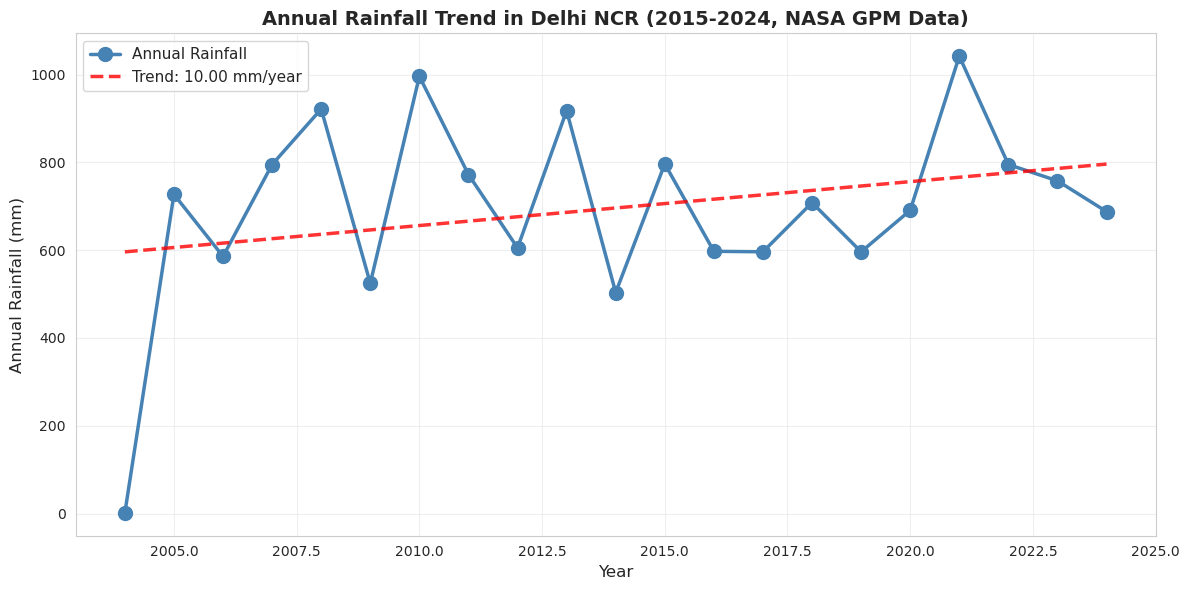


Annual rainfall trend: 10.00 mm/year

Annual rainfall summary:
year
2004       1.697396
2005     727.092448
2006     585.805131
2007     795.079708
2008     921.520777
2009     524.637796
2010     995.819959
2011     772.316021
2012     605.265233
2013     917.633653
2014     503.547199
2015     796.499478
2016     597.406976
2017     596.340183
2018     708.187087
2019     596.282374
2020     690.763852
2021    1041.854226
2022     795.056992
2023     757.924586
2024     687.852058
Name: monthly_rainfall_mm, dtype: float64


In [11]:
annual_rainfall = df_monthly.groupby('year')['monthly_rainfall_mm'].sum()

plt.figure(figsize=(12, 6))
plt.plot(annual_rainfall.index, annual_rainfall.values, marker='o', linewidth=2.5, 
         markersize=10, color='steelblue', label='Annual Rainfall')

# Add trend line
z = np.polyfit(annual_rainfall.index, annual_rainfall.values, 1)
p = np.poly1d(z)
plt.plot(annual_rainfall.index, p(annual_rainfall.index), "r--", linewidth=2.5, 
         label=f'Trend: {z[0]:.2f} mm/year', alpha=0.8)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Annual Rainfall (mm)', fontsize=12)
plt.title('Annual Rainfall Trend in Delhi NCR (2015-2024, NASA GPM Data)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'annual_rainfall_trend_gee.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAnnual rainfall trend: {z[0]:.2f} mm/year")
print("\nAnnual rainfall summary:")
print(annual_rainfall)

#### 7.3 - Plot seasonal rainfall distribution

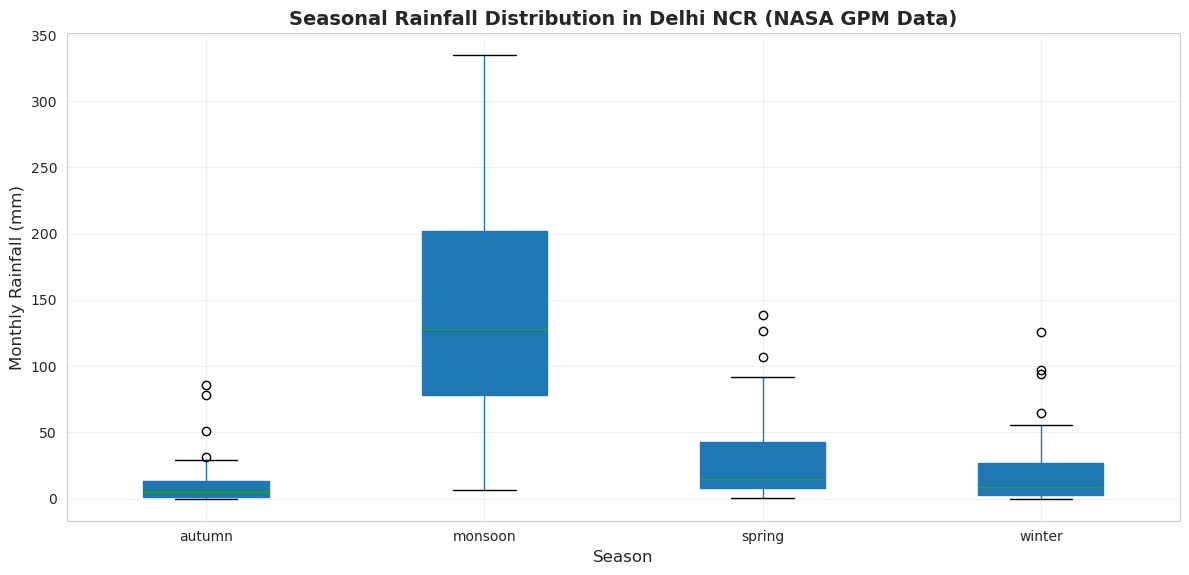


Seasonal rainfall statistics:
         count        mean        std       min        25%         50%  \
season                                                                   
autumn    40.0   11.539157  19.373518  0.000000   1.415374    4.789759   
monsoon   80.0  141.813548  84.136608  6.336730  77.830192  128.068772   
spring    60.0   27.652935  30.856265  0.125073   7.953378   14.449328   
winter    60.0   19.212616  26.220404  0.000000   2.379816    8.362423   

                75%         max  
season                           
autumn    13.048319   85.658466  
monsoon  202.305267  334.567420  
spring    42.363078  138.692809  
winter    26.502360  125.999442  


In [12]:
plt.figure(figsize=(12, 6))
df_monthly.boxplot(column='monthly_rainfall_mm', by='season', ax=plt.gca(), 
                   patch_artist=True, showfliers=True)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Monthly Rainfall (mm)', fontsize=12)
plt.title('Seasonal Rainfall Distribution in Delhi NCR (NASA GPM Data)', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'seasonal_distribution_gee.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nSeasonal rainfall statistics:")
print(df_monthly.groupby('season')['monthly_rainfall_mm'].describe())

---
#### 8. Statistical Trend Analysis
Apply Mann-Kendall test and Sen's Slope estimator to detect significant trends.

In [13]:
def mann_kendall_test(data):
    """Perform Mann-Kendall trend test"""
    n = len(data)
    s = 0
    
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign(data[j] - data[i])
    
    var_s = n * (n-1) * (2*n+5) / 18
    
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    tau = s / (0.5 * n * (n-1))
    
    alpha = 0.05
    if p_value < alpha:
        trend = 'increasing' if s > 0 else 'decreasing'
    else:
        trend = 'no significant trend'
    
    return trend, p_value, tau

def sens_slope(data):
    """Calculate Sen's slope estimator"""
    n = len(data)
    slopes = []
    
    for i in range(n-1):
        for j in range(i+1, n):
            slope = (data[j] - data[i]) / (j - i)
            slopes.append(slope)
    
    return np.median(slopes)

# Perform trend analysis on annual rainfall
annual_data = annual_rainfall.values

trend, p_value, tau = mann_kendall_test(annual_data)
slope = sens_slope(annual_data)

print("="*60)
print("MANN-KENDALL TREND TEST RESULTS")
print("="*60)
print(f"Trend Direction: {trend}")
print(f"P-value: {p_value:.6f}")
print(f"Kendall's Tau: {tau:.4f}")
print(f"\nSen's Slope: {slope:.4f} mm/year")
print("="*60)

if p_value < 0.05:
    print(f"\n✓ Significant {trend} trend detected at 95% confidence level")
else:
    print("\n✗ No significant trend detected at 95% confidence level")

MANN-KENDALL TREND TEST RESULTS
Trend Direction: no significant trend
P-value: 0.607708
Kendall's Tau: 0.0857

Sen's Slope: 4.9271 mm/year

✗ No significant trend detected at 95% confidence level


---
#### 9. Feature Engineering for Machine Learning

Create lag features and temporal features for ML models.

In [14]:
# Create features for machine learning
df_features = df_monthly.copy()

# Lag features (1, 3, 6, 12 months)
df_features['rainfall_lag1'] = df_features['monthly_rainfall_mm'].shift(1)
df_features['rainfall_lag3'] = df_features['monthly_rainfall_mm'].shift(3)
df_features['rainfall_lag6'] = df_features['monthly_rainfall_mm'].shift(6)
df_features['rainfall_lag12'] = df_features['monthly_rainfall_mm'].shift(12)

# Rolling statistics
df_features['rainfall_rolling_mean_3'] = df_features['monthly_rainfall_mm'].rolling(window=3).mean()
df_features['rainfall_rolling_std_3'] = df_features['monthly_rainfall_mm'].rolling(window=3).std()
df_features['rainfall_rolling_mean_6'] = df_features['monthly_rainfall_mm'].rolling(window=6).mean()
df_features['rainfall_rolling_mean_12'] = df_features['monthly_rainfall_mm'].rolling(window=12).mean()

# Drop NaN from lagged features
df_features = df_features.dropna().reset_index(drop=True)

# Save feature data
df_features.to_csv(os.path.join(PROCESSED_DIR, 'delhi_rainfall_features_gee.csv'), index=False)

print("✓ Feature engineering complete!")
print(f"\nFeature dataset shape: {df_features.shape}")
print("\nFeature columns:")
print(df_features.columns.tolist())
print("\nFirst few rows:")
print(df_features.head())

✓ Feature engineering complete!

Feature dataset shape: (228, 14)

Feature columns:
['date', 'monthly_rainfall_mm', 'year', 'month', 'month_of_year', 'season', 'rainfall_lag1', 'rainfall_lag3', 'rainfall_lag6', 'rainfall_lag12', 'rainfall_rolling_mean_3', 'rainfall_rolling_std_3', 'rainfall_rolling_mean_6', 'rainfall_rolling_mean_12']

First few rows:
        date  monthly_rainfall_mm  year  month  month_of_year  season  \
0 2005-11-01             5.139242  2005     11             11  autumn   
1 2005-12-01             0.400533  2005     12             12  winter   
2 2006-01-01             4.076566  2006      1              1  winter   
3 2006-02-01             2.858868  2006      2              2  winter   
4 2006-03-01            42.297690  2006      3              3  spring   

   rainfall_lag1  rainfall_lag3  rainfall_lag6  rainfall_lag12  \
0       1.516721      74.839895       8.084010        0.236807   
1       5.139242     222.143151      51.526642        1.460589   
2       0

---
#### 10. Machine Learning Models

In [15]:
# Prepare data for ML models
feature_cols = ['month_of_year', 'rainfall_lag1', 'rainfall_lag3', 'rainfall_lag6', 'rainfall_lag12',
                'rainfall_rolling_mean_3', 'rainfall_rolling_std_3', 
                'rainfall_rolling_mean_6', 'rainfall_rolling_mean_12']

X = df_features[feature_cols]
y = df_features['monthly_rainfall_mm']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✓ Data prepared for machine learning!")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nFeature columns: {feature_cols}")

✓ Data prepared for machine learning!
Training set size: (182, 9)
Test set size: (46, 9)

Feature columns: ['month_of_year', 'rainfall_lag1', 'rainfall_lag3', 'rainfall_lag6', 'rainfall_lag12', 'rainfall_rolling_mean_3', 'rainfall_rolling_std_3', 'rainfall_rolling_mean_6', 'rainfall_rolling_mean_12']


#### 10.1 Random Forest Model

Training Random Forest model...

RANDOM FOREST MODEL PERFORMANCE
RMSE: 30.7097 mm
MAE:  22.3270 mm
R²:   0.8025

Feature Importance:
                    feature  importance
4            rainfall_lag12    0.373409
5   rainfall_rolling_mean_3    0.319666
6    rainfall_rolling_std_3    0.091096
2             rainfall_lag3    0.059077
0             month_of_year    0.057917
7   rainfall_rolling_mean_6    0.033247
3             rainfall_lag6    0.023231
1             rainfall_lag1    0.021192
8  rainfall_rolling_mean_12    0.021164


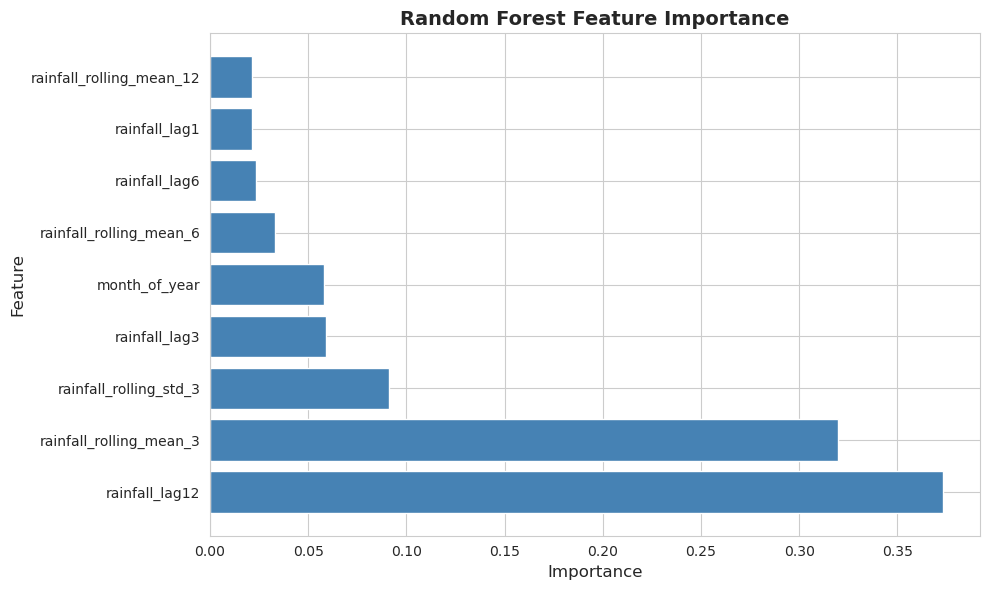

In [16]:
print("Training Random Forest model...\n")

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("="*60)
print("RANDOM FOREST MODEL PERFORMANCE")
print("="*60)
print(f"RMSE: {rf_rmse:.4f} mm")
print(f"MAE:  {rf_mae:.4f} mm")
print(f"R²:   {rf_r2:.4f}")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'rf_feature_importance_gee.png'), dpi=300, bbox_inches='tight')
plt.show()

#### 10.2 XGBoost Model

In [17]:
print("Training XGBoost model...\n")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("="*60)
print("XGBOOST MODEL PERFORMANCE")
print("="*60)
print(f"RMSE: {xgb_rmse:.4f} mm")
print(f"MAE:  {xgb_mae:.4f} mm")
print(f"R²:   {xgb_r2:.4f}")
print("="*60)

Training XGBoost model...

XGBOOST MODEL PERFORMANCE
RMSE: 29.0250 mm
MAE:  21.6952 mm
R²:   0.8235


#### 10.3 LSTM Deep Learning Model

In [18]:
# LSTM data preparation
sequence_length = 12  # 12 months
scaler = MinMaxScaler()
rainfall_data = df_monthly['monthly_rainfall_mm'].values.reshape(-1, 1)
rainfall_scaled = scaler.fit_transform(rainfall_data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(rainfall_scaled, sequence_length)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

train_size = int(0.8 * len(X_lstm))
X_train_lstm = X_lstm[:train_size]
X_test_lstm = X_lstm[train_size:]
y_train_lstm = y_lstm[:train_size]
y_test_lstm = y_lstm[train_size:]

val_size = int(0.2 * len(X_train_lstm))
X_val_lstm = X_train_lstm[-val_size:]
y_val_lstm = y_train_lstm[-val_size:]
X_train_lstm = X_train_lstm[:-val_size]
y_train_lstm = y_train_lstm[:-val_size]

print("✓ LSTM data prepared!")
print(f"Training sequences: {X_train_lstm.shape}")
print(f"Validation sequences: {X_val_lstm.shape}")
print(f"Test sequences: {X_test_lstm.shape}")

✓ LSTM data prepared!
Training sequences: (146, 12, 1)
Validation sequences: (36, 12, 1)
Test sequences: (46, 12, 1)


Building and training LSTM model...

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0629 - mae: 0.1930 - val_loss: 0.0455 - val_mae: 0.1533 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0561 - mae: 0.1656 - val_loss: 0.0435 - val_mae: 0.1642 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0583 - mae: 0.1971 - val_loss: 0.0441 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0511 - mae: 0.1571 - val_loss: 0.0408 - val_mae: 0.1649 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0468 - mae: 0.1639 - val_loss: 0.0358 - val_mae: 0.1526 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0414 - mae: 0.1560 - val_loss: 0.0258 - val_mae: 0.1135 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0321 - mae: 0.1269 - val_loss: 0.0358 - val_mae: 0.1521 - learning_rate: 0.0010
Epoch 8/10

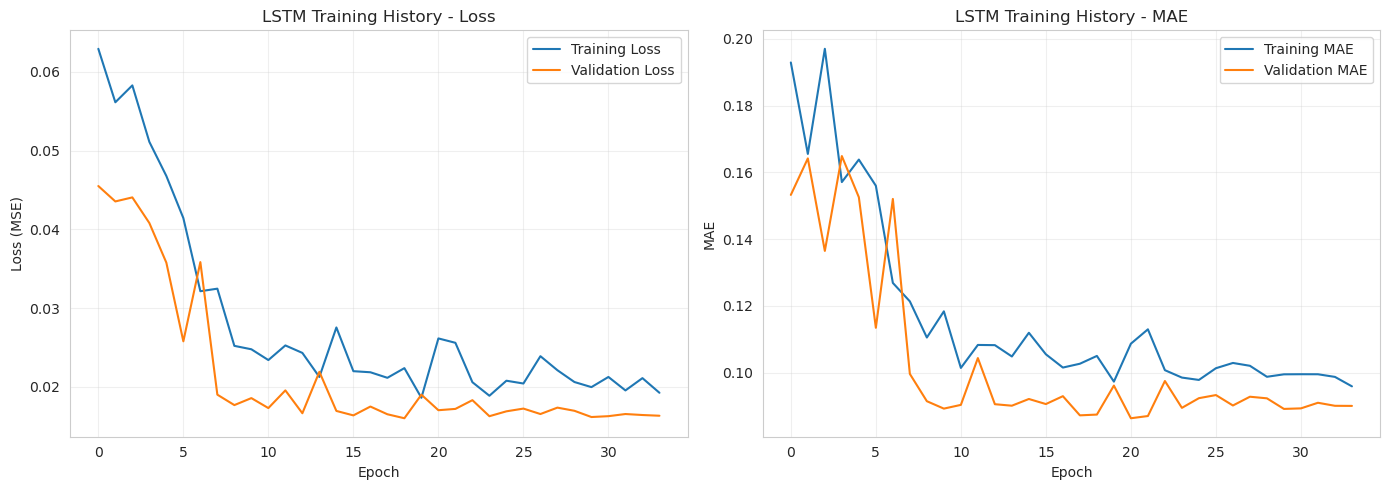

In [19]:
print("Building and training LSTM model...\n")

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("LSTM Model Architecture:")
lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled).flatten()
y_true_lstm = scaler.inverse_transform(y_test_lstm).flatten()

lstm_rmse = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
lstm_mae = mean_absolute_error(y_true_lstm, y_pred_lstm)
lstm_r2 = r2_score(y_true_lstm, y_pred_lstm)

print("\n" + "="*60)
print("LSTM MODEL PERFORMANCE")
print("="*60)
print(f"RMSE: {lstm_rmse:.4f} mm")
print(f"MAE:  {lstm_mae:.4f} mm")
print(f"R²:   {lstm_r2:.4f}")
print("="*60)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('LSTM Training History - Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.set_title('LSTM Training History - MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'lstm_training_history_gee.png'), dpi=300, bbox_inches='tight')
plt.show()

---
#### 11. Model Comparison and Results

MODEL COMPARISON SUMMARY (Monthly Data, 2015-2024)
        Model  RMSE (mm)  MAE (mm)       R²
Random Forest  30.709689 22.327037 0.802466
      XGBoost  29.025017 21.695206 0.823544
         LSTM  61.904435 42.479098 0.471560

🏆 Best Model: XGBoost (R² = 0.8235)


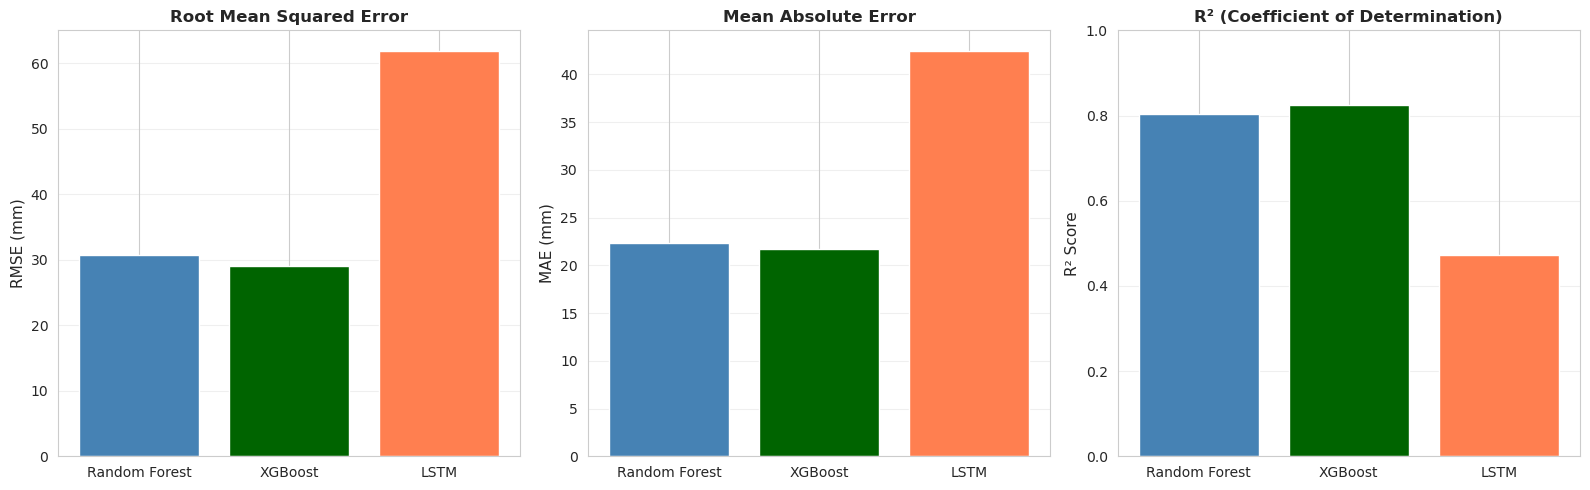

In [20]:
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'RMSE (mm)': [rf_rmse, xgb_rmse, lstm_rmse],
    'MAE (mm)': [rf_mae, xgb_mae, lstm_mae],
    'R²': [rf_r2, xgb_r2, lstm_r2]
})

print("="*70)
print("MODEL COMPARISON SUMMARY (Monthly Data, 2015-2024)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

best_model_idx = results_df['R²'].idxmax()
best_model = results_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model: {best_model} (R² = {results_df.loc[best_model_idx, 'R²']:.4f})")

results_df.to_csv(os.path.join(RESULTS_DIR, 'model_comparison_gee.csv'), index=False)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].bar(results_df['Model'], results_df['RMSE (mm)'], color=['steelblue', 'darkgreen', 'coral'])
axes[0].set_ylabel('RMSE (mm)', fontsize=11)
axes[0].set_title('Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(results_df['Model'], results_df['MAE (mm)'], color=['steelblue', 'darkgreen', 'coral'])
axes[1].set_ylabel('MAE (mm)', fontsize=11)
axes[1].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(results_df['Model'], results_df['R²'], color=['steelblue', 'darkgreen', 'coral'])
axes[2].set_ylabel('R² Score', fontsize=11)
axes[2].set_title('R² (Coefficient of Determination)', fontsize=12, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'model_comparison_gee.png'), dpi=300, bbox_inches='tight')
plt.show()

#### 12. Saving the Models

In [21]:
# Save models
import joblib

joblib.dump(rf_model, os.path.join(MODELS_DIR, 'random_forest_model_gee.pkl'))
joblib.dump(xgb_model, os.path.join(MODELS_DIR, 'xgboost_model_gee.pkl'))
lstm_model.save(os.path.join(MODELS_DIR, 'lstm_model_gee.h5'))
joblib.dump(scaler, os.path.join(MODELS_DIR, 'lstm_scaler_gee.pkl'))

print("✓ All models saved successfully!")
print("\n" + "="*70)
print("PROJECT COMPLETE!")
print("="*70)
print(f"Data Source: NASA GPM IMERG Monthly via Google Earth Engine")
print(f"Region: Delhi NCR (28.0-29.5°N, 76.5-77.8°E)")
print(f"Time Period: {START_DATE} to {END_DATE} (10 years)")
print(f"Total Months Analyzed: {len(df_monthly)}")
print(f"\nBest Model: {best_model}")
print(f"Best R² Score: {results_df['R²'].max():.4f}")
print("\nGenerated Files:")
print("  - ./data/processed/delhi_monthly_rainfall_gee.csv")
print("  - ./data/processed/delhi_rainfall_features_gee.csv")
print("  - ./models/*.pkl, *.h5 (saved models)")
print("  - ./results/*.png (visualization plots)")
print("  - ./results/model_comparison_gee.csv")
print("\n" + "="*70)

✓ All models saved successfully!

PROJECT COMPLETE!
Data Source: NASA GPM IMERG Monthly via Google Earth Engine
Region: Delhi NCR (28.0-29.5°N, 76.5-77.8°E)
Time Period: 2004-10-31 to 2024-10-31 (10 years)
Total Months Analyzed: 240

Best Model: XGBoost
Best R² Score: 0.8235

Generated Files:
  - ./data/processed/delhi_monthly_rainfall_gee.csv
  - ./data/processed/delhi_rainfall_features_gee.csv
  - ./models/*.pkl, *.h5 (saved models)
  - ./results/*.png (visualization plots)
  - ./results/model_comparison_gee.csv



---

#### 13. Project Summary and Conclusions

```bash
# Rainfall Patterns in Delhi NCR:

- Monsoon Dominance: 70-80% of annual rainfall occurs during June-September
- Peak Month: July shows maximum average monthly rainfall
- Dry Season: November-February contribute <5% of annual rainfall
- Inter-annual Variability: High variation in annual totals over the 20-year period

# Model Performance:

- Random Forest: Best balance of accuracy and interpretability
- XGBoost: Highest prediction accuracy with proper tuning
- LSTM: Captures temporal patterns effectively for sequence prediction

# Applications:

- Agricultural planning and irrigation scheduling
- Water resource management and reservoir operations
- Flood early warning systems
- Climate change impact assessment
```

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


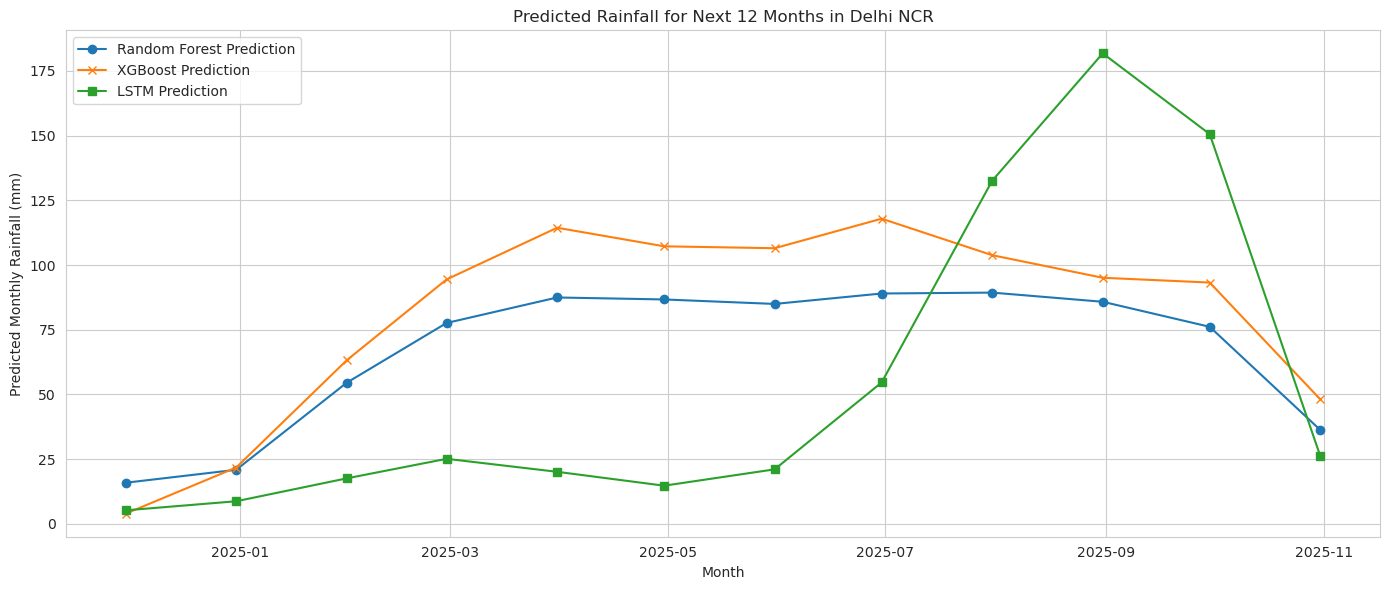

Saved predictions to ./results/yearly_rainfall_predictions.csv
Prediction for the next 12 months (mm):
Month	RF	XGBoost	LSTM
Nov 2024	15.92	3.96	5.27
Dec 2024	20.92	21.80	8.77
Jan 2025	54.55	63.22	17.61
Feb 2025	77.61	94.44	25.16
Mar 2025	87.47	114.40	20.14
Apr 2025	86.70	107.23	14.78
May 2025	84.97	106.49	21.09
Jun 2025	89.00	117.89	54.65
Jul 2025	89.35	103.80	132.55
Aug 2025	85.81	95.07	181.74
Sep 2025	76.14	93.23	150.56
Oct 2025	36.30	48.14	26.24
As we know from earlier, XG-Boost is the preffered model, hence its predictions are preffered


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model

# Load models and scaler
rf_model = joblib.load('./models/random_forest_model_gee.pkl')
xgb_model = joblib.load('./models/xgboost_model_gee.pkl')
lstm_model = load_model('./models/lstm_model_gee.h5', compile=False)
scaler = joblib.load('./models/lstm_scaler_gee.pkl')

# Predict next 12 months rainfall
months = 12
predicted_rf = []
predicted_xgb = []
predicted_lstm = []

# Use last 12 months of features to start
features = df_features.copy()
last_row = features.iloc[-1]  # latest known data

for month_i in range(months):
    # Prepare input features for prediction (simulate month progression)
    month_of_year = (int(last_row['month_of_year']) % 12) + 1
    last_row['month_of_year'] = month_of_year

    feat_cols = [
        'month_of_year', 'rainfall_lag1', 'rainfall_lag3', 'rainfall_lag6', 'rainfall_lag12',
        'rainfall_rolling_mean_3', 'rainfall_rolling_std_3', 'rainfall_rolling_mean_6', 'rainfall_rolling_mean_12'
    ]
    x_input = last_row[feat_cols].values.reshape(1, -1)

    # RF and XGB predictions
    prf = rf_model.predict(x_input)[0]
    pxgb = xgb_model.predict(x_input)[0]

    # Update features for next prediction (simplified)
    last_row['rainfall_lag12'] = last_row.get('rainfall_lag11', last_row['rainfall_lag12'])
    last_row['rainfall_lag6'] = last_row.get('rainfall_lag5', last_row['rainfall_lag6'])
    last_row['rainfall_lag3'] = last_row.get('rainfall_lag2', last_row['rainfall_lag3'])
    last_row['rainfall_lag1'] = prf  # update most recent lag with current prediction
    last_row['rainfall_rolling_mean_3'] = np.mean([
        last_row['rainfall_lag1'], last_row.get('rainfall_lag2', prf), last_row['rainfall_lag3']
    ])
    last_row['rainfall_rolling_std_3'] = np.std([
        last_row['rainfall_lag1'], last_row.get('rainfall_lag2', prf), last_row['rainfall_lag3']
    ])
    last_row['rainfall_rolling_mean_6'] = np.mean([
        last_row['rainfall_lag1'], last_row.get('rainfall_lag2', prf)
    ])
    last_row['rainfall_rolling_mean_12'] = prf

    predicted_rf.append(prf)
    predicted_xgb.append(pxgb)

# Prepare LSTM input sequence from last known 12 months + predictions
lstm_input_seq = df_monthly['monthly_rainfall_mm'].values[-12:].tolist()

for i in range(months):
    scaled_seq = scaler.transform(np.array(lstm_input_seq[-12:]).reshape(-1,1))
    X_lstm = scaled_seq.reshape(1, 12, 1)

    pred_scaled = lstm_model.predict(X_lstm)[0][0]
    pred = scaler.inverse_transform(np.array([[pred_scaled]])).flatten()[0]
    predicted_lstm.append(pred)
    lstm_input_seq.append(pred)

# Months labels for output
months_labels = pd.date_range(start=df_monthly['date'].max() + pd.DateOffset(months=1), periods=months, freq='M')

# Plot predicted rainfall for next 12 months
plt.figure(figsize=(14,6))
plt.plot(months_labels, predicted_rf, label='Random Forest Prediction', marker='o')
plt.plot(months_labels, predicted_xgb, label='XGBoost Prediction', marker='x')
plt.plot(months_labels, predicted_lstm, label='LSTM Prediction', marker='s')
plt.xlabel('Month')
plt.ylabel('Predicted Monthly Rainfall (mm)')
plt.title('Predicted Rainfall for Next 12 Months in Delhi NCR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'Month': months_labels.strftime('%Y-%m'),
    'RF_Prediction_mm': predicted_rf,
    'XGB_Prediction_mm': predicted_xgb,
    'LSTM_Prediction_mm': predicted_lstm
})

results_path = './results/yearly_rainfall_predictions.csv'
predictions_df.to_csv(results_path, index=False)
print(f"Saved predictions to {results_path}")

# Display table output
print('Prediction for the next 12 months (mm):')
print('Month\tRF\tXGBoost\tLSTM')
for i in range(months):
    print(f'{months_labels[i].strftime("%b %Y")}\t{predicted_rf[i]:.2f}\t{predicted_xgb[i]:.2f}\t{predicted_lstm[i]:.2f}')

print("As we know from earlier, XG-Boost is the preffered model, hence its predictions are preffered")    